# Analyze H&E features with Kmeans clustering / For training_27 / For breast_s6

In [1]:
slide_id = "breast_s6"

**¡¡ RQ: cellvit features done for masks using nuclei segmentation !!**

In [2]:
import numpy as np
from tqdm import tqdm
import gc
import numpy as np

import anndata as ad
import scanpy as sc
import spatialdata as sd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from kneed import KneeLocator

## Cluster H&E features

In [3]:
def process_features_to_adata(features, feature_prefix):
    """
    Convert features dictionary directly to AnnData format without using Pandas DataFrame.
    """
    # Prepare lists for obs and feature matrix (X)
    cell_ids = []
    patch_ids_list = []
    feature_matrix = []

    for cell_id, (features_array, patch_ids) in tqdm(features.items()):
        # Process patch_ids: Convert to string and remove `.png`
        processed_patch_ids = [str(patch_id).replace('.png', '') for patch_id in patch_ids]
        
        # Collect data
        cell_ids.append(cell_id)
        patch_ids_list.append(','.join(processed_patch_ids))  # Join list into a string for compatibility
        feature_matrix.append(features_array)

    # Convert feature matrix to NumPy array
    feature_matrix = np.array(feature_matrix, dtype=np.float32)

    # Create obs (observations) with cell_id and patch_ids
    obs = {
        'cell_id': cell_ids,
        'patch_ids': patch_ids_list
    }

    # Create var (variables) with feature names
    num_features = feature_matrix.shape[1]
    var = {
        'index': [f"{feature_prefix}{i}" for i in range(num_features)]
    }

    # Create AnnData object
    adata = ad.AnnData(X=feature_matrix, obs=obs, var=var)

    return adata

In [4]:
t27_ini_cellvit = np.load(f"/Volumes/DD1_FGS/MICS/data_HE2CellType/CT_DS/analyze_trained_model/training_27/output_model/{slide_id}/cell_features_cellvit.npy", allow_pickle=True).item()
adata_ini_t27 = process_features_to_adata(t27_ini_cellvit, feature_prefix=f"HE_t27_")
adata_ini_t27

100%|██████████| 692139/692139 [00:00<00:00, 2299717.41it/s]


AnnData object with n_obs × n_vars = 692139 × 1280
    obs: 'cell_id', 'patch_ids'
    var: 'index'

In [5]:
# Filter cells with NA values for features
adata_t27 = adata_ini_t27[np.isnan(adata_ini_t27.X).sum(axis=1) == 0].copy()
print(f"Number of cells with NA values removed: {adata_ini_t27.shape[0] - adata_t27.shape[0]}")

del adata_ini_t27
gc.collect()

print(adata_t27)

Number of cells with NA values removed: 0
AnnData object with n_obs × n_vars = 692139 × 1280
    obs: 'cell_id', 'patch_ids'
    var: 'index'


Finding optimal components: 100%|██████████| 1/1 [00:34<00:00, 34.85s/it]


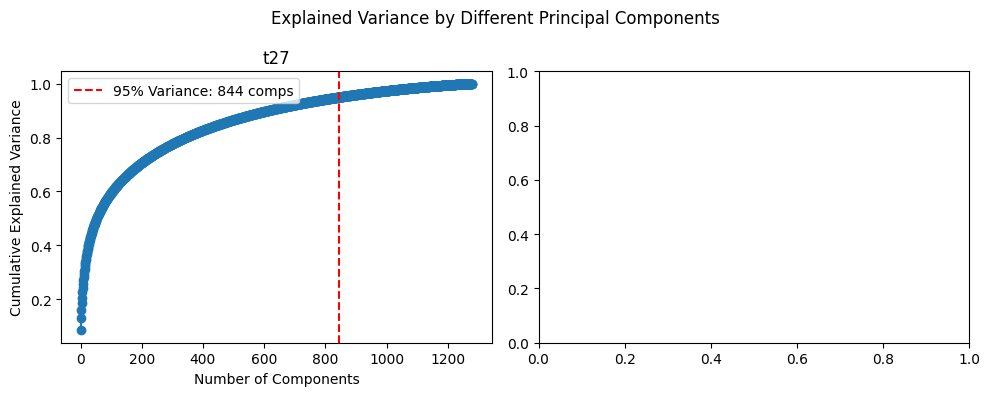

Model: t27, Optimal Components for 95% Variance: 844


In [6]:
# Find the best number of components for each model

datasets = {"t27": adata_t27}
scaled_features_all = {"t27": []}

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

optimal_components = {}

for ax, model_name in tqdm(zip(axes, datasets.keys()), total=len(datasets), desc="Finding optimal components"):
    
    # Ensure X is of type float32
    datasets[model_name].X = datasets[model_name].X.astype('float32')

    # Scale features to unit variance
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(datasets[model_name].X)
    scaled_features_all[model_name] = scaled_features

    # Fit PCA on scaled data
    pca = PCA().fit(scaled_features)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

    # Find the number of components explaining 95% variance
    n_components = np.argmax(cumulative_variance >= 0.95) + 1
    optimal_components[model_name] = n_components

    # Plotting the Cumulative Summation of the Explained Variance
    ax.plot(range(1, len(pca.explained_variance_ratio_) + 1), cumulative_variance, marker='o')
    ax.axvline(n_components, linestyle='--', color='r', label=f'95% Variance: {n_components} comps')
    ax.set_xlabel('Number of Components')
    ax.set_ylabel('Cumulative Explained Variance')
    ax.set_title(model_name)
    ax.legend()

plt.suptitle('Explained Variance by Different Principal Components')
plt.tight_layout()
plt.show()

# Print optimal number of components
for model_name, n_components in optimal_components.items():
    print(f"Model: {model_name}, Optimal Components for 95% Variance: {n_components}")

In [7]:
# Choose best number of components for each model
n_components = optimal_components # {"t27"}

In [8]:
# Applying PCA with the optimal number of components
pca_results = {"t27": []}
for model_name in tqdm(datasets.keys(), desc="Applying PCA"):
    pca = PCA(n_components=n_components[model_name], random_state=42)
    pca_result = pca.fit_transform(scaled_features_all[model_name]) # The pca_result is an array with the transformed features
    pca_results[model_name] = pca_result

Applying PCA: 100%|██████████| 1/1 [01:18<00:00, 78.24s/it]


Finding optimal clusters for t27: 100%|██████████| 10/10 [01:38<00:00,  9.87s/it]


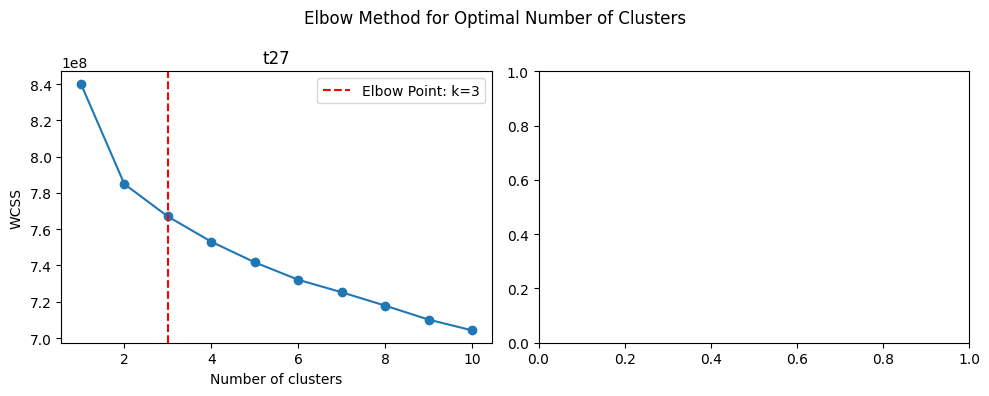

Optimal number of clusters for t27: 3


In [9]:
# Find the optimal number of clusters using the Elbow Method

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
optimal_clusters = {}

for ax, model_name in zip(axes, datasets.keys()):
    wcss = []
    for k in tqdm(range(1, 11), desc=f"Finding optimal clusters for {model_name}"):
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(pca_results[model_name])
        wcss.append(kmeans.inertia_)

    # Use KneeLocator to find the elbow point
    kl = KneeLocator(range(1, 11), wcss, curve="convex", direction="decreasing")
    elbow = kl.knee
    optimal_clusters[model_name] = elbow

    # Plot the WCSS curve and mark the elbow point
    ax.plot(range(1, 11), wcss, marker='o')
    ax.axvline(elbow, linestyle='--', color='r', label=f'Elbow Point: k={elbow}')
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('WCSS')
    ax.set_title(model_name)
    ax.legend()

plt.suptitle('Elbow Method for Optimal Number of Clusters')
plt.tight_layout()
plt.show()

# Print the optimal number of clusters for each model
for model_name, elbow in optimal_clusters.items():
    print(f"Optimal number of clusters for {model_name}: {elbow}")

In [10]:
# Choose the optimal number of clusters for each model
n_clusters = optimal_clusters # {"t27": tochoose}

Processing models: 100%|██████████| 1/1 [00:09<00:00,  9.88s/it]


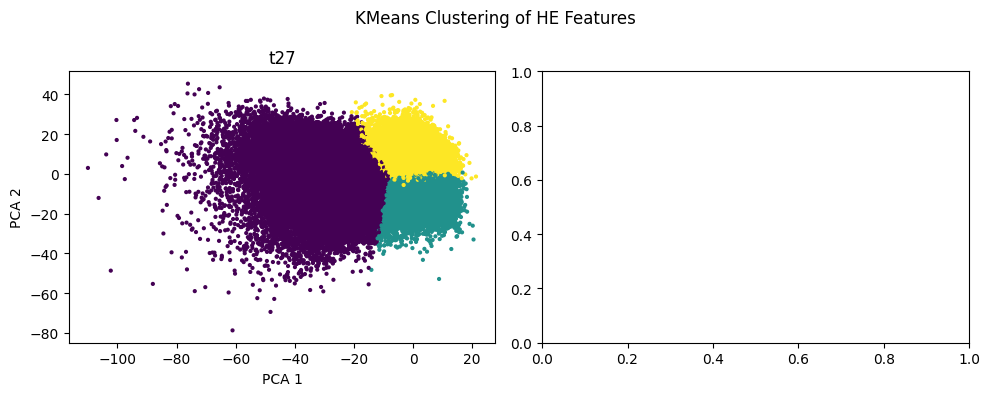

In [11]:
# Apply KMeans clustering with the optimal number of clusters

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

for ax, model_name in tqdm(zip(axes, datasets.keys()), total=len(datasets), desc='Processing models'):

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters[model_name], random_state=42)
    cluster_labels = kmeans.fit_predict(pca_results[model_name])
    datasets[model_name].obs[f"kmeans_clusterHE_{model_name}"] = cluster_labels.astype(str) # adding the cluster labels to the adata
    datasets[model_name].obsm[f"X_pca_{model_name}"] = pca_results[model_name] # adding also pca results in the adata

    # Plot the clusters
    ax.scatter(pca_results[model_name][:, 0], pca_results[model_name][:, 1], c=cluster_labels, cmap='viridis', s=4)
    ax.set_title(model_name)
    ax.set_xlabel('PCA 1')
    ax.set_ylabel('PCA 2')

plt.suptitle('KMeans Clustering of HE Features')
plt.tight_layout()
plt.show()

## Compare H&E clusters with clusters using RNA information

In [12]:
sdata = sd.read_zarr(f"/Volumes/DD1_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_{slide_id}.zarr", selection=('tables',))

# Clear the memory
del sdata.tables['table_combined']
del sdata.tables['table_nuclei']
del sdata.tables['table_scvi']
del sdata.tables['features_cellvit']
del sdata.tables['features_phikonv2']
del sdata.tables['features_vit_google']
gc.collect()

sdata

/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'cell_boundaries', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)
/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/spatialdata/_core/spatialdata.py:158: UserWarning: The table is annotating 'nucleus_boundaries', which is not present in the SpatialData object.
  self.validate_table_in_spatialdata(v)


SpatialData object, with associated Zarr store: /Volumes/DD1_FGS/MICS/data_HE2CellType/CT_DS/sdata_final/sdata_breast_s6.zarr
└── Tables
      └── 'table_cells': AnnData (692184, 5101)
with coordinate systems:

with the following elements in the Zarr store but not in the SpatialData object:
    ▸ table_combined (Tables)
    ▸ features_vit_google (Tables)
    ▸ morpho (Images)
    ▸ features_cellvit (Tables)
    ▸ table_nuclei (Tables)
    ▸ nucleus_boundaries (Shapes)
    ▸ he_patches (Shapes)
    ▸ he (Images)
    ▸ cell_boundaries (Shapes)
    ▸ st (Points)
    ▸ table_scvi (Tables)
    ▸ features_phikonv2 (Tables)

In [13]:
sdata.tables['table_cells']

AnnData object with n_obs × n_vars = 692184 × 5101
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'region', 'z_level', 'pca_n20_pcs16_leiden_res0.2', 'pca_n20_pcs16_leiden_res0.4', 'pca_n20_pcs16_leiden_res0.6', 'refine_res', 'label1', 'label2', 'label3', 'transcript_cat', 'transcript_counts_log', 'PanNuke_label', 'PanNuke_proba', 'final_label', 'kmeans_clustersHE_cellvit', 'kmeans_clustersHE_phikonv2', 'kmeans_clustersHE_vit_google'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    uns: 'final_label_colors', 'label1_colors', 'label2_colors', 'label3_colors', 'leiden', 'pca', 'pca_n20_pcs16', 'pca_n20_pcs16_leiden_res0.2_colors', 'pca_n20_pcs16_leiden_res0.4_colors', 'pca_n20_pcs16_leiden_res0.6_colors', 'rank_genes_refine_res', 'refine_res_colors', 'spatial

In [14]:
def HE_on_RNA(sdata, datasets, neighbors_key_cells):
    
    for model in datasets.keys():

        # Add the adata_features to sdata
        sdata.tables[f"features_{model}"] = datasets[model].copy()
        
        # Add the features cluster to table_cells, table_nuclei and table_combined
        id2cluster = dict(datasets[model].obs[['cell_id', f'kmeans_clusterHE_{model}']].values)
        for table_name in ['table_cells']:
            sdata.tables[table_name].obs[f'kmeans_clustersHE_{model}'] = sdata.tables[table_name].obs['cell_id'].map(id2cluster).fillna('-1').astype('category')
    
    print("For table_cells:")
    sc.pl.umap(sdata.tables['table_cells'][(sdata.tables['table_cells'].obs["transcript_counts"]>10)],
               neighbors_key=neighbors_key_cells,
               color=['label1', 'final_label', 'kmeans_clustersHE_t27'],
               ncols=3)

For table_cells:


/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/felicie-giraud-sauveur/miniforge3/envs/cluster/lib/python3.10/site-packages/a

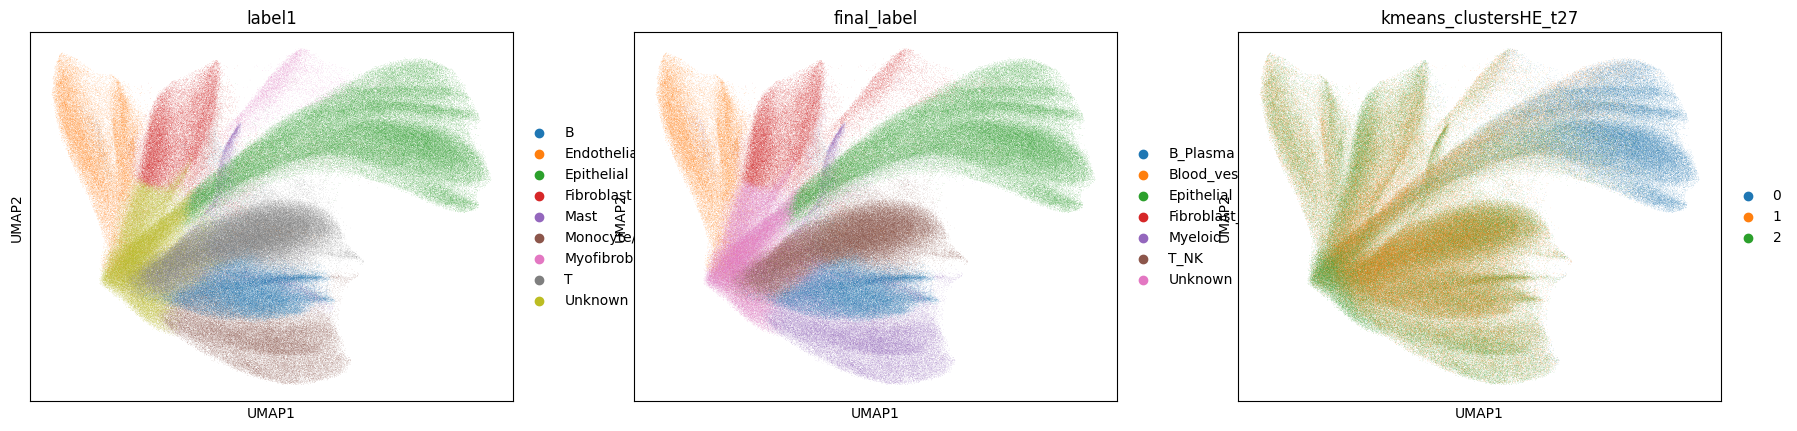

In [15]:
HE_on_RNA(sdata, datasets, neighbors_key_cells='pca_n10_pcs16')